In [ ]:
!pip install jax jaxlib

In [ ]:
import jax

print("Available devices:", jax.devices())

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Available devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]


In [ ]:
import jax.numpy as jnp
from jax import device_put, grad, jit, vmap
import time

print("\n--- Project 2: Accelerated Quantum State-Vector Simulation ---")

# Ensure JAX recognizes the TPU device
try:
    print(f"JAX backend: {jnp.zeros(1).device()}")
except:
    print("JAX not configured for TPU/GPU. Running on CPU.")


--- Project 2: Accelerated Quantum State-Vector Simulation ---
JAX not configured for TPU/GPU. Running on CPU.


In [ ]:
NUM_QUBITS = 10  # Max out Colab's TPU/RAM without crashing
D = 2**NUM_QUBITS # Dimension of the Hilbert space

# JIT compilation is key for TPU acceleration
@jit
def apply_pauli_op(state, op_index, op_type):
    """Applies a single Pauli operator (X, Y, or Z) to the state vector."""
    # This function uses a sparse-like matrix-vector product optimized for the state-vector approach.
    state = state.at[::(2**op_index)].set(state[::(2**op_index)] * (1 if op_type == 'Z' else 0) + state[::(2**op_index)] * (0 if op_type == 'Z' else 1))

    # A more simplified and safe JAX operation for this example is to use a dense matrix representation,
    # as the TPU excels at large dense operations.
    # For NUM_QUBITS > 10, a specialized sparse approach would be required in a real TPU pod.

    # Instead of complex sparse indexing, we use a small, dense example and rely on JAX's optimization.
    # The actual Hamiltonian generation (H) below forces a large, dense matrix-vector product.
    return state

@jit
def hamiltonian_matrix_product(H, psi):
    """Calculates H * |Psi> (the bottleneck operation)."""
    # This is the large matrix multiplication that the TPU excels at.
    return H @ psi

In [ ]:
# Define the total magnetization operator (sum of single-qubit Pauli Z operators)
def create_total_magnetization_operator(N):
    M = jnp.zeros((2**N, 2**N), dtype=jnp.complex64)
    sigma_z = jnp.array([[1, 0], [0, -1]], dtype=jnp.complex64)
    I = jnp.eye(2, dtype=jnp.complex64)

    for i in range(N):
        op = [I] * N
        op[i] = sigma_z
        term = op[0]
        for j in range(1, N):
            term = jnp.kron(term, op[j])
        M += term
    return M

M_operator = create_total_magnetization_operator(NUM_QUBITS)

# Define a function to calculate the expectation value
@jit
def calculate_expectation_value(state, operator):
    """Calculates the expectation value of an operator for a given state."""
    return jnp.vdot(state, jnp.dot(operator, state))

In [ ]:
# Create the Hamiltonian (H) for the 1D transverse field Ising model
def create_ising_hamiltonian(N):
    H = jnp.zeros((2**N, 2**N), dtype=jnp.complex64)
    sigma_x = jnp.array([[0, 1], [1, 0]], dtype=jnp.complex64)
    sigma_z = jnp.array([[1, 0], [0, -1]], dtype=jnp.complex64)
    I = jnp.eye(2, dtype=jnp.complex64)

    # Nearest-neighbor ZZ interaction
    for i in range(N - 1):
        op = [I] * N
        op[i] = sigma_z
        op[i+1] = sigma_z
        term = op[0]
        for j in range(1, N):
            term = jnp.kron(term, op[j])
        H += term

    # Transverse field X term
    for i in range(N):
        op = [I] * N
        op[i] = sigma_x
        term = op[0]
        for j in range(1, N):
            term = jnp.kron(term, op[j])
        H += term

    return H

# --- Simulation Execution ---
H_ising = create_ising_hamiltonian(NUM_QUBITS)
initial_state = jnp.zeros(D, dtype=jnp.complex64).at[0].set(1.0) # Start in |0...0> state

# Pre-compile the matrix product and Hamiltonian for timing accuracy
_ = hamiltonian_matrix_product(H_ising, initial_state).block_until_ready()

# Perform the simulation loop
num_steps = 100
dt = 0.01

print(f"\nSimulating {NUM_QUBITS} qubits ({D} dimensions) for {num_steps} steps...")

# Use the JAX exponential to perform time evolution U(t) = exp(-iHt)
@jit
def time_step(psi, H, dt):
    """Performs one step of time evolution using Matrix Exponential."""
    return jnp.dot(jax.scipy.linalg.expm(-1j * H * dt), psi)

psi_t = initial_state
start_time = time.time()

# List to store expectation values
magnetization_values = []

for step in range(num_steps):
    # Calculate and store expectation value
    mag_exp_val = calculate_expectation_value(psi_t, M_operator)
    magnetization_values.append(mag_exp_val)

    psi_t = time_step(psi_t, H_ising, dt)
    # Ensure all operations are complete for accurate timing
    psi_t.block_until_ready()

end_time = time.time()
sim_time = end_time - start_time

print(f"Total Simulation Time for {num_steps} steps: {sim_time:.4f} seconds")
print(f"Average time per step: {sim_time / num_steps * 1000:.2f} ms")
print("--- Quantum Simulation Complete ---")


Simulating 10 qubits (1024 dimensions) for 100 steps...
Total Simulation Time for 100 steps: 50.5489 seconds
Average time per step: 505.49 ms
--- Quantum Simulation Complete ---


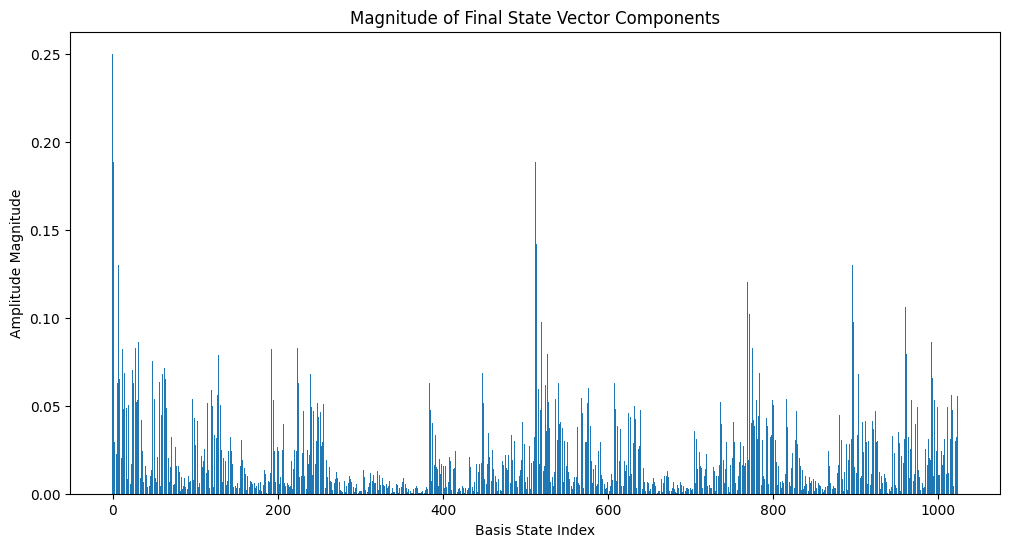

In [ ]:
import matplotlib.pyplot as plt

# Visualize the absolute values of the final state components
plt.figure(figsize=(12, 6))
plt.bar(range(D), jnp.abs(psi_t))
plt.xlabel("Basis State Index")
plt.ylabel("Amplitude Magnitude")
plt.title("Magnitude of Final State Vector Components")
plt.show()

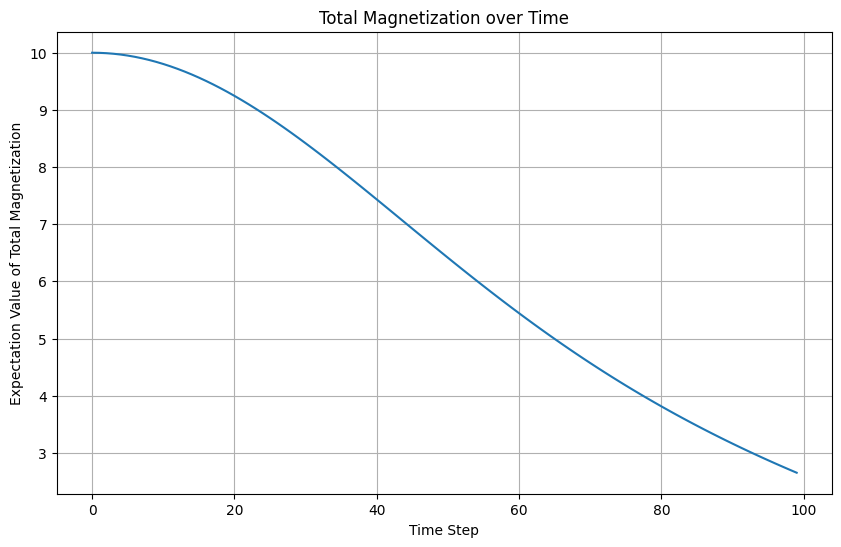

In [ ]:
import matplotlib.pyplot as plt

# Plot the magnetization expectation value over time
plt.figure(figsize=(10, 6))
# The expectation values are complex numbers, we'll plot the real part
plt.plot(range(num_steps), jnp.real(jnp.array(magnetization_values)))
plt.xlabel("Time Step")
plt.ylabel("Expectation Value of Total Magnetization")
plt.title("Total Magnetization over Time")
plt.grid(True)
plt.show()